![seQuencing logo](../images/sequencing-logo.*)

# Pulse Sequences

One of the main functions of the `sequencing` package is to manage the construction of time-dependent Hamiltonians to be used in [qutip master equation simulations](http://qutip.org/docs/4.1/guide/dynamics/dynamics-master.html). This is accomplished by an object called a [PulseSequence](../api/classes.rst#PulseSequence). If you just want to get started simulating some quantum systems, start with [quickstart](#Quickstart). For a more detailed explanation of `PulseSequence`, see [under the hood](#Under-the-hood).

## Quickstart

Once you have put togehter a quantum [System](../api/classes.rst#System), you can create a fresh `PulseSequence` using the function `get_sequence(system)` (see [get_sequence()](../api/functions.rst#get-sequence)). Once the `PulseSequence` has been created, calling any function that is wrapped with the [decorator](https://www.python.org/dev/peps/pep-0318/) `@capture_operation` (see [capture_operation](../api/functions.rst#capture-operation)) and that returns an [Operation](../api/classes.rst#Operation) object will automatically add that that operation to the current sequence, effectively slotting it into the time-dependent Hamiltonian of the system. Any such function can be called with the keyword argument `capture=False` in order to return the `Operation` directly rather than "capturing" it and adding it to the current sequence.

A `PulseSequence` behaves just like a Python `list`: you can `append`, `extend`, `insert`, `pop`, `clear`, and iterate over it. A `PulseSequence` can be compiled at any time into a [CompiledPulseSequence](../api/classes.rst#CompiledPulseSequence) by calling `PulseSequence.compile()`.

## Using `get_sequence()`

While it is possible to instantiate a `PulseSequence` or `CompiledPulseSequence` directly, the recommended way to generate a fresh sequence is by calling `get_sequence(system)`, where `system` is an instance of `System` that has already been defined. For convenience, `sequencing` defines a single global `PulseSequence` instance which can be fetched as-is by calling `get_sequence()` with no arguments, or fetched and "reset" before being returned by calling `get_sequence(system)`.

The existence of this global pulse list object is what enables the `@capture_operation` decorator to work its magic. `seq = get_sequence(system)` should be called at the beginning of each distinct simulation you want to run, so that `@capture_operation` knows where to direct the `Operations` that it captures. The workflow for a set of simulations looks like:

1. Define your `system` (modes, drift Hamiltonian, and coherence properties)
2. For each distinct simulation you wish to run:
    - Call `seq = get_sequence(system)` to create a fresh sequence
    - Construct the time-dependent Hamiltonian by calling functions decorated by `@capture_operations`, in combination with any of the [sequence scheduling functions discussed below](#Scheduling-a-pulse-sequence)
    - (Optionally, plot the time-dependent Hamiltonian coefficients by calling `seq.plot_coefficients()`)
    - Once the sequence is complete, call `result = seq.run(init_state)`, where `init_state` is the initial state of the system (e.g. `init_state = system.ground_state()`), to run the master equation simulation.

In [1]:
# %matplotlib notebook
import inspect
import matplotlib.pyplot as plt
import numpy as np
import qutip
from sequencing import (
    Transmon, Cavity, System, get_sequence, sync, delay, delay_channels,
    HTerm, CTerm, Operation, capture_operation
)

Instantiate your `Modes` and `System`:

In [2]:
qubit = Transmon('qubit', levels=3, kerr=-200e-3)
cavity = Cavity('cavity', levels=10, kerr=-10e-6)
system = System('system', modes=[qubit, cavity])
system.set_cross_kerr(cavity, qubit, chi=-2e-3)

Define a function that performs an `Operation` on a `Mode`, and decorate it with `@capture_operation`

Before calling sine_operation: len(seq) = 0
After calling sine_operation: len(seq) = 1


<IPython.core.display.Javascript object>


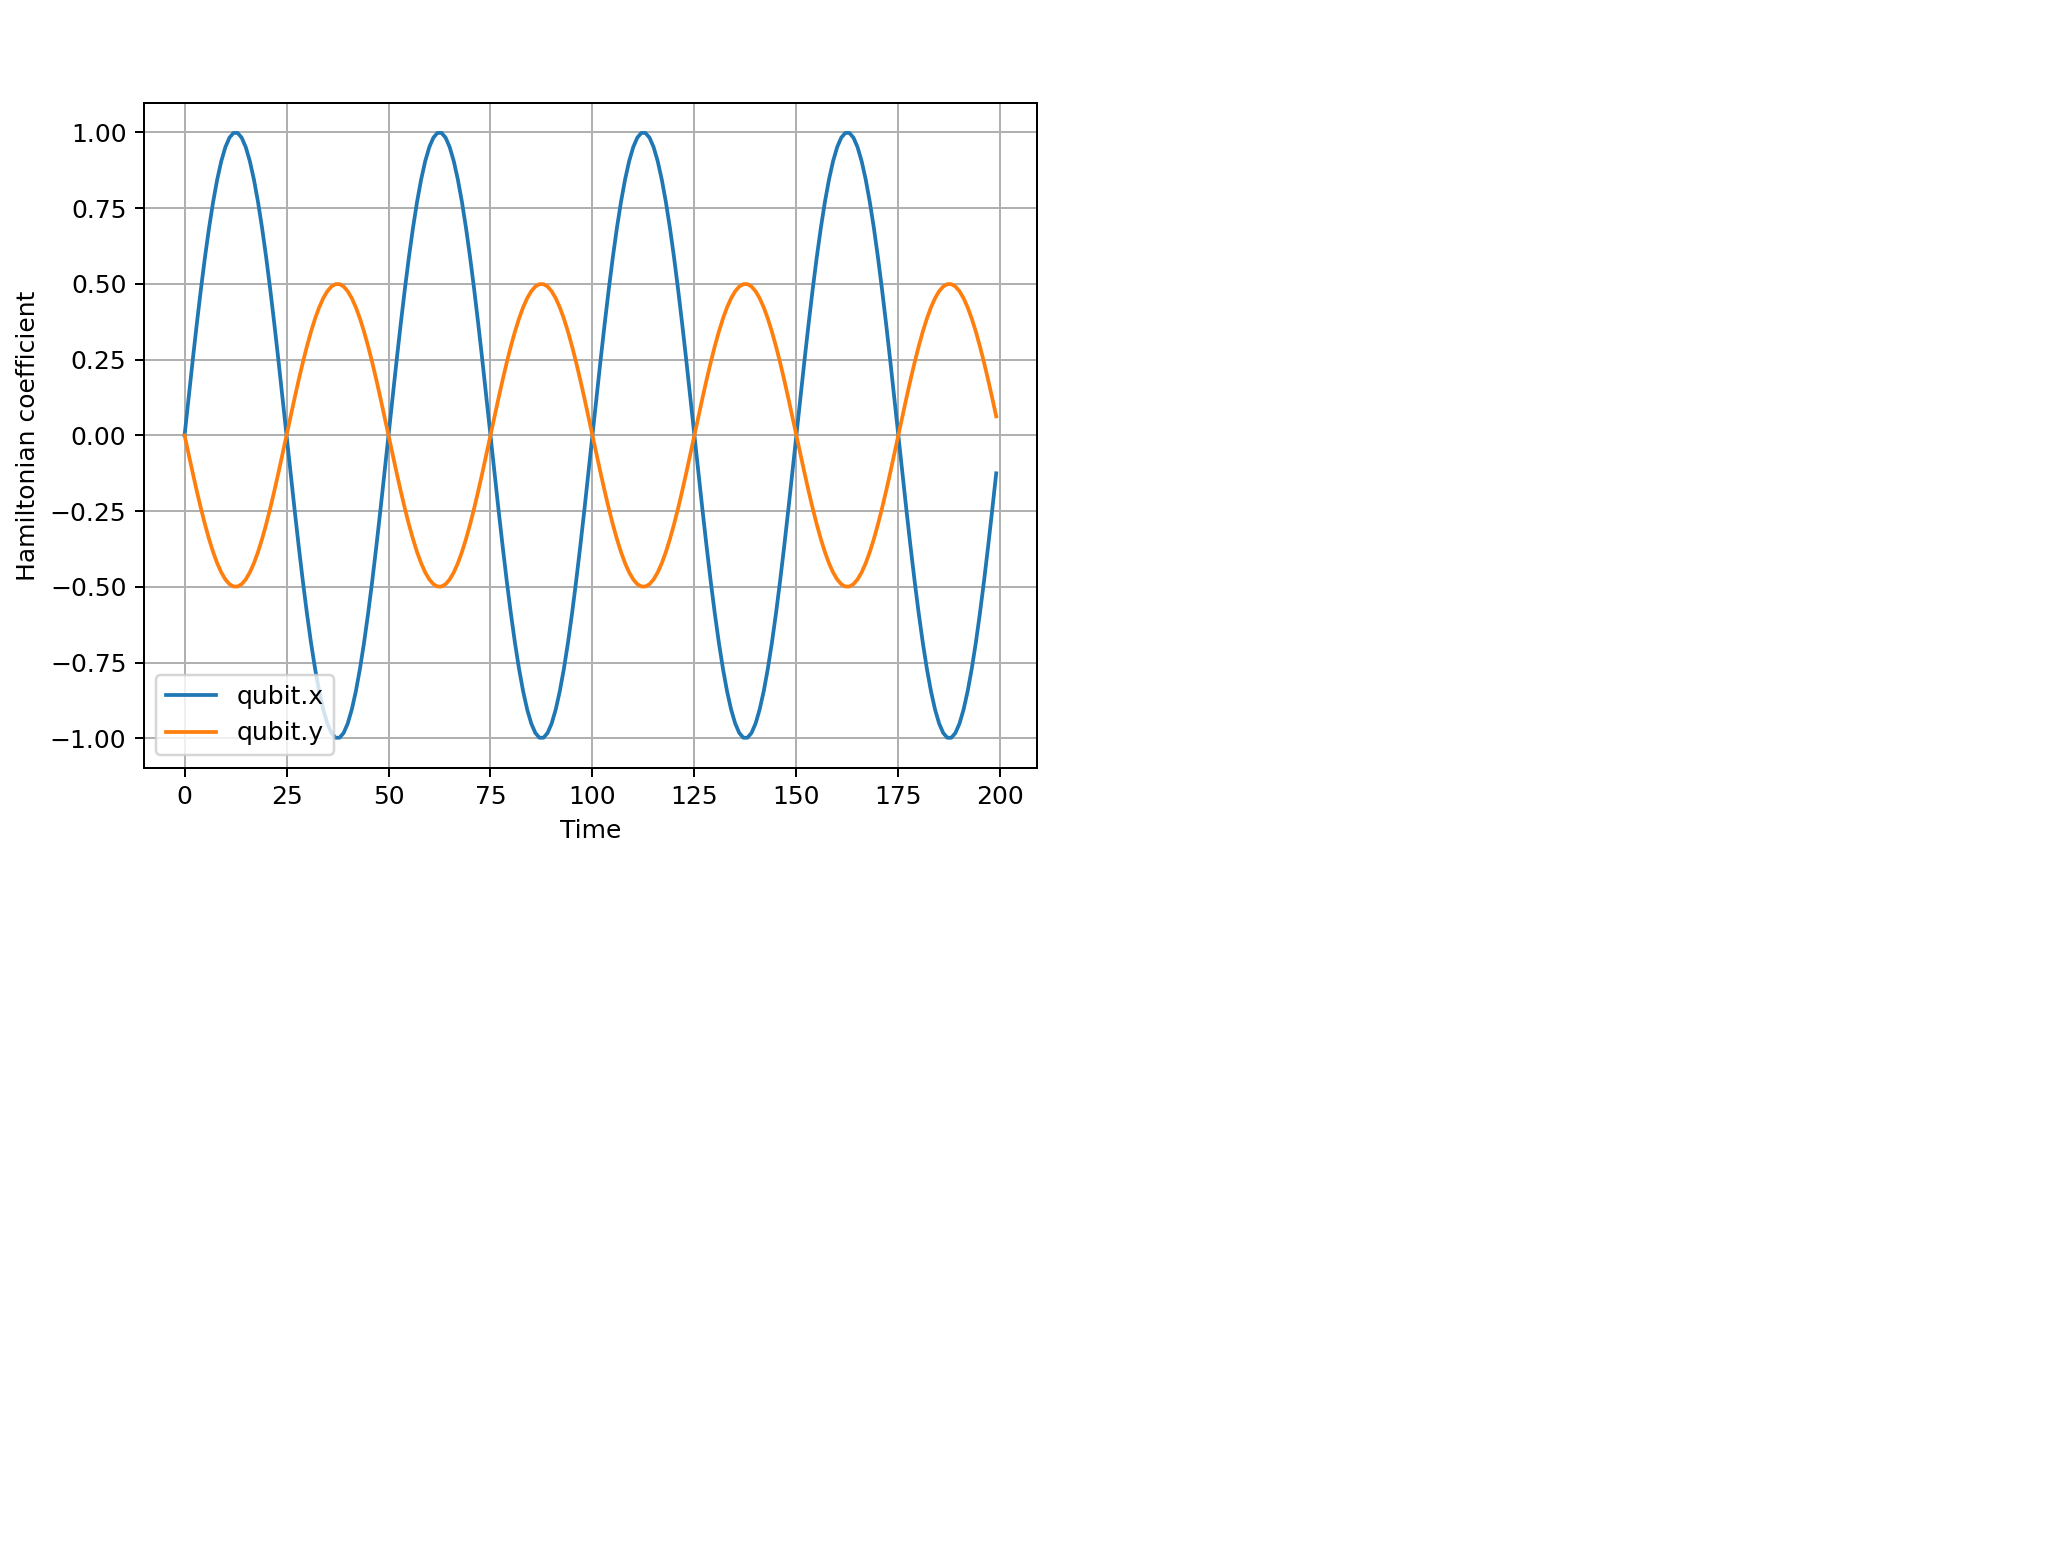

In [3]:
@capture_operation
def sine_operation(mode, f0, length):
    times = np.arange(length)
    coeffs = np.sin(2 * np.pi * f0 * times)
    terms = {
        f'{mode.name}.x': HTerm(H=mode.x, coeffs=coeffs),
        f'{mode.name}.y': HTerm(H=mode.y, coeffs=-0.5*coeffs),
    }
    return Operation(duration=len(times), terms=terms)

seq = get_sequence(system)
assert isinstance(sine_operation(qubit, 4e-2, 100, capture=False), Operation) # operation not captured

print(f'Before calling sine_operation: len(seq) = {len(seq)}')
assert sine_operation(qubit, 2e-2, 200) is None # operation captured by seq
print(f'After calling sine_operation: len(seq) = {len(seq)}')

fig, ax = seq.plot_coefficients(subplots=False)

Important methods decorated with `@capture_operation` include [Transmon.rotate()](../api/classes.rst#Transmon) and [Cavity.displace()](../api/classes.rst#Cavity).

Of course the user is encouraged to define their own functions that return `Operations` as needed (and decorate them appropriately!).

## Scheduling a pulse sequence

The timing of a `PulseSequence` is determined the `duration` of its constituent `Operations` and by the inclusion of [sync()](../api/functions.rst#sync) statements in the sequence. A `sync` ensures that all of the Hamiltonian channels align in time up to the point of the `sync()` statement. Ths means that all operations which follow the `sync` will be executed after all those before the sync. `CompiledPulseSequences` are constructed in terms of blocks of `Operations` separated by `syncs`. Sets of operations within a block are made to have equal duration by padding shorter operations to the maximum sequence length. 

**Note:** If multiple `Operations` include the same Hamiltonian channel (operator), then the coefficients for that operator within that block simply add together. 

In total, there are three different functions used for scheduling `PulseSequence`:

- [sync()](../api/functions.rst#sync): appends a [SyncOperation](../api/classes.rst#SyncOperation) to the `PulseSequence`
- [delay()](../api/functions.rst#delay): adds a global delay/idle on all Hamiltonian channels by appending a [DelayOperation](../api/classes.rst#DelayOperation) to the `PulseSequence`
- [delay_channels()](../api/functions.rst#delay-channels) adds a delay/idle to one or more channels relative to all other channels by appending a [DelayChannelsOperation](../api/classes.rst#DelayChannelsOperation) to the `PulseSequence`

In [4]:
print('sync():')
print('\t' + '\n\t'.join(inspect.getdoc(sync).split('\n')) + '\n')

print('delay(length, sync_before=True, sync_after=True):')
print('\t' + '\n\t'.join(inspect.getdoc(delay).split('\n')) + '\n')

print('delay_channels(channels, length):')
print('\t'+'\n\t'.join(inspect.getdoc(delay_channels).split('\n')))

sync():
	Ensure that the Hamiltonian channels all align up to this point.
	
	This means that all operations which follow the sync will be
	executed after all those before the sync. Sequences are constructed
	in terms of blocks of operations separated by sync()s.
	Within a block, channels are made to have equal duration by padding
	shorter channels to the maximum channel length.
	
	Args:
	    seq (optional, CompiledPulseSequence): CompiledPulseSequence on
	        which to apply the sync. If None, a SyncOperation is appended
	        to the global PulseSequence. Default: None.

delay(length, sync_before=True, sync_after=True):
	Adds a global delay to the sequence,
	delaying all channels by the same amount.
	
	Args:
	    length (int): Length of the delay.
	    sync_before (optional, bool): Whether to insert a sync() before
	        the delay. Default: True.
	    sync_after (optional, bool): Whether to insert a sync() after
	        the delay. Default: True.
	    seq (optional, CompiledPu

### Visualizing a pulse sequence

<IPython.core.display.Javascript object>


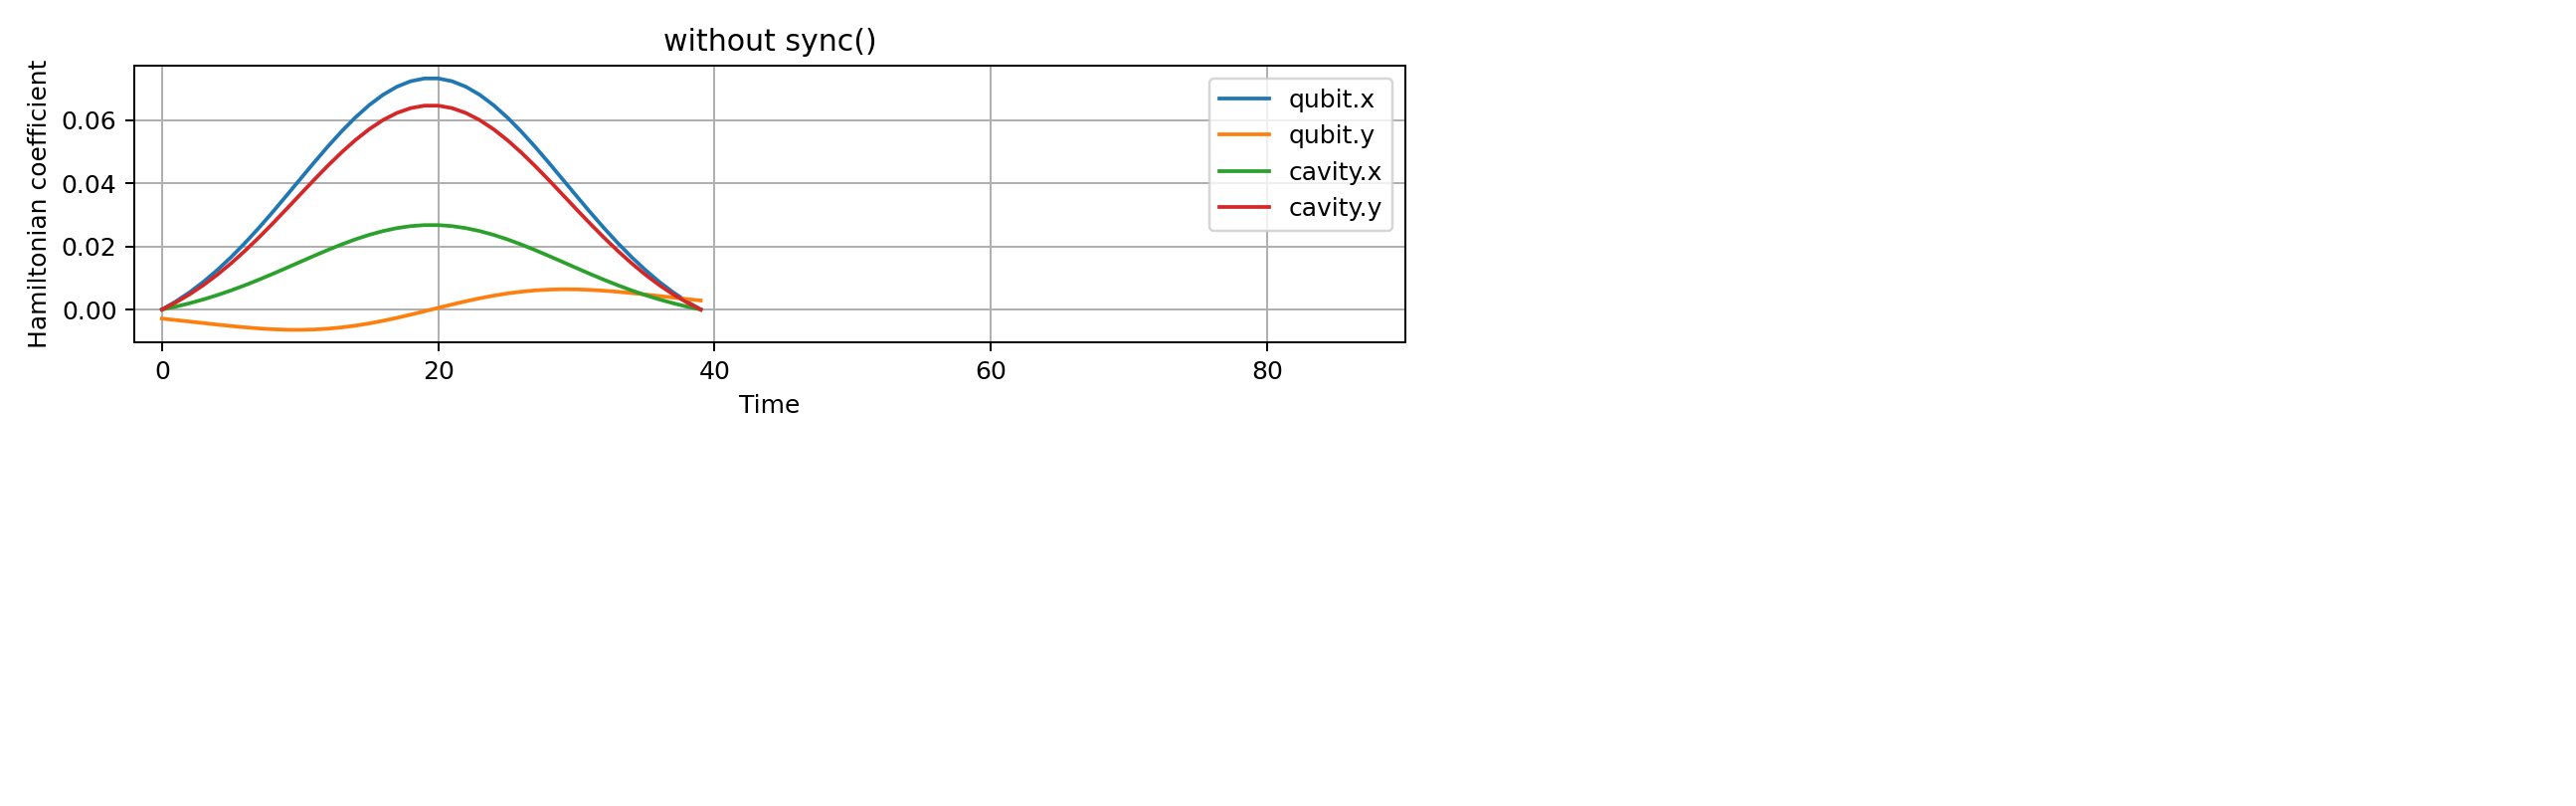

<IPython.core.display.Javascript object>


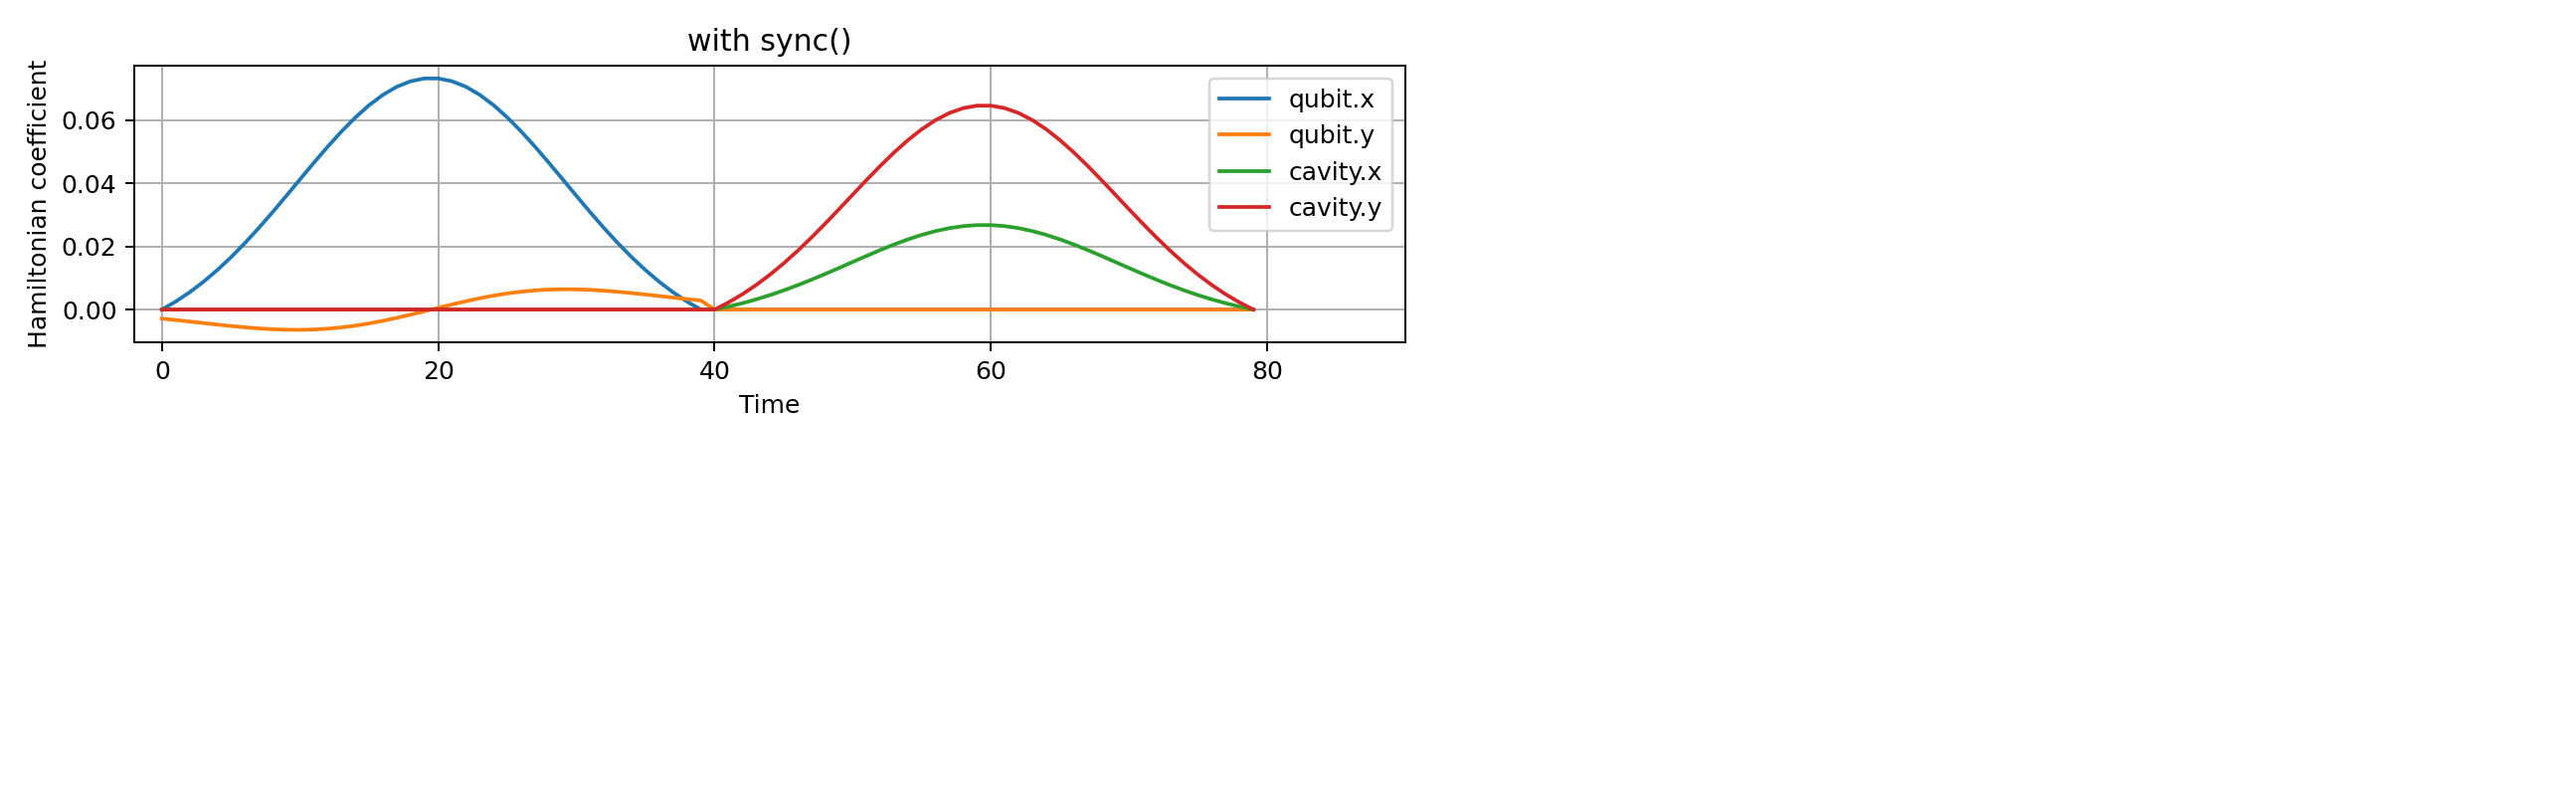

<IPython.core.display.Javascript object>


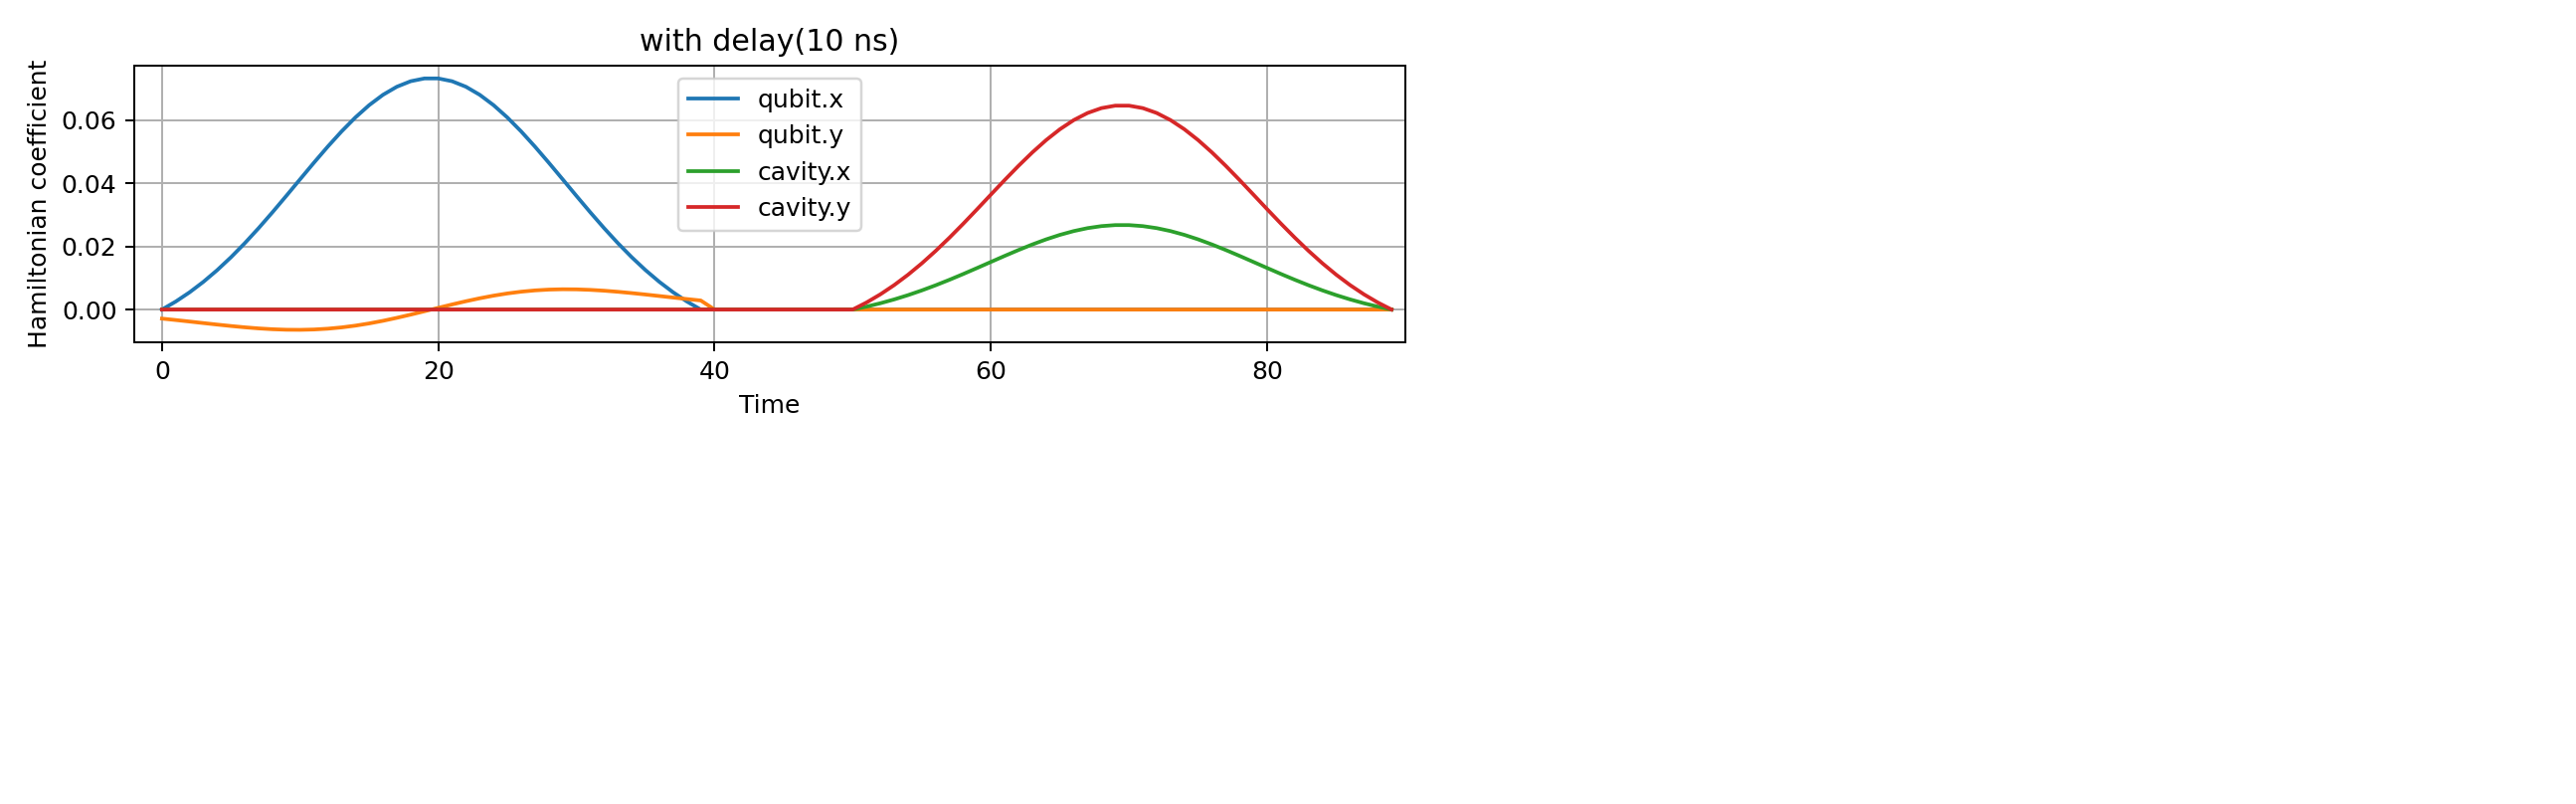

<IPython.core.display.Javascript object>


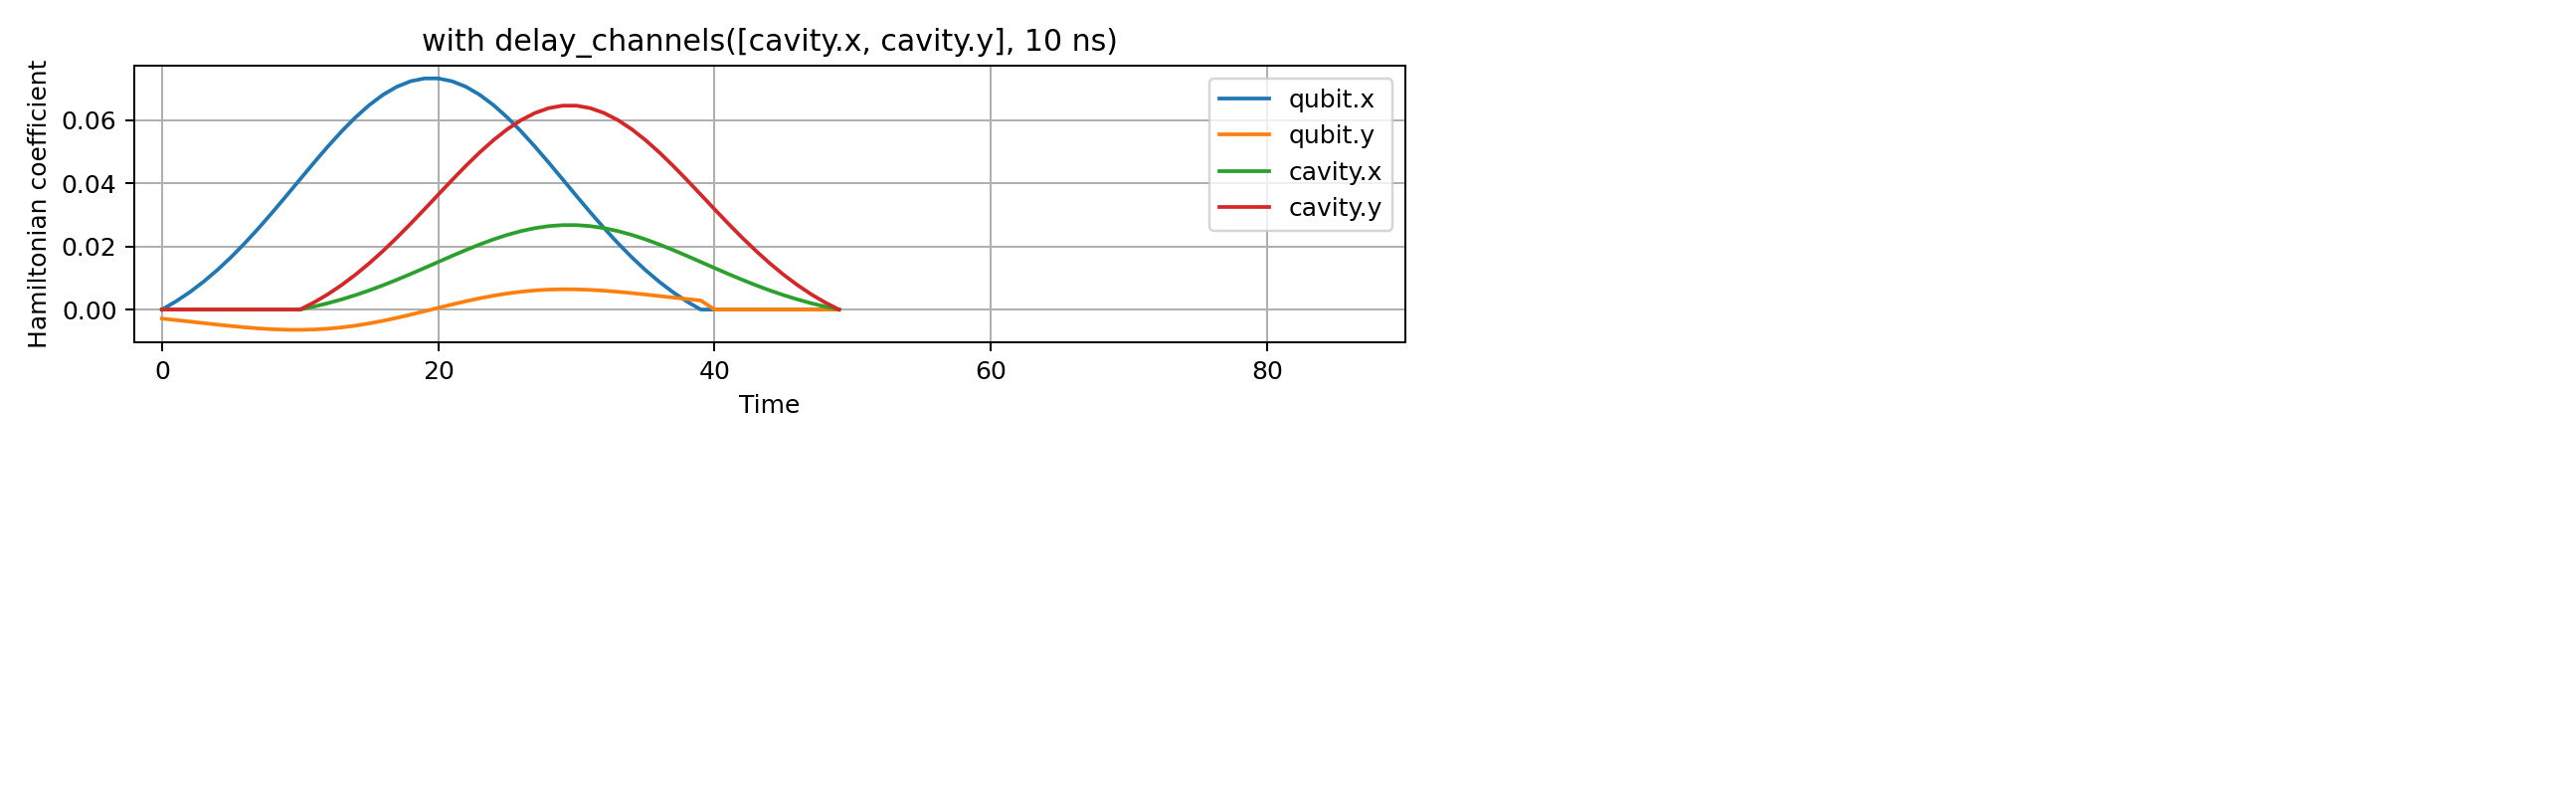

<IPython.core.display.Javascript object>


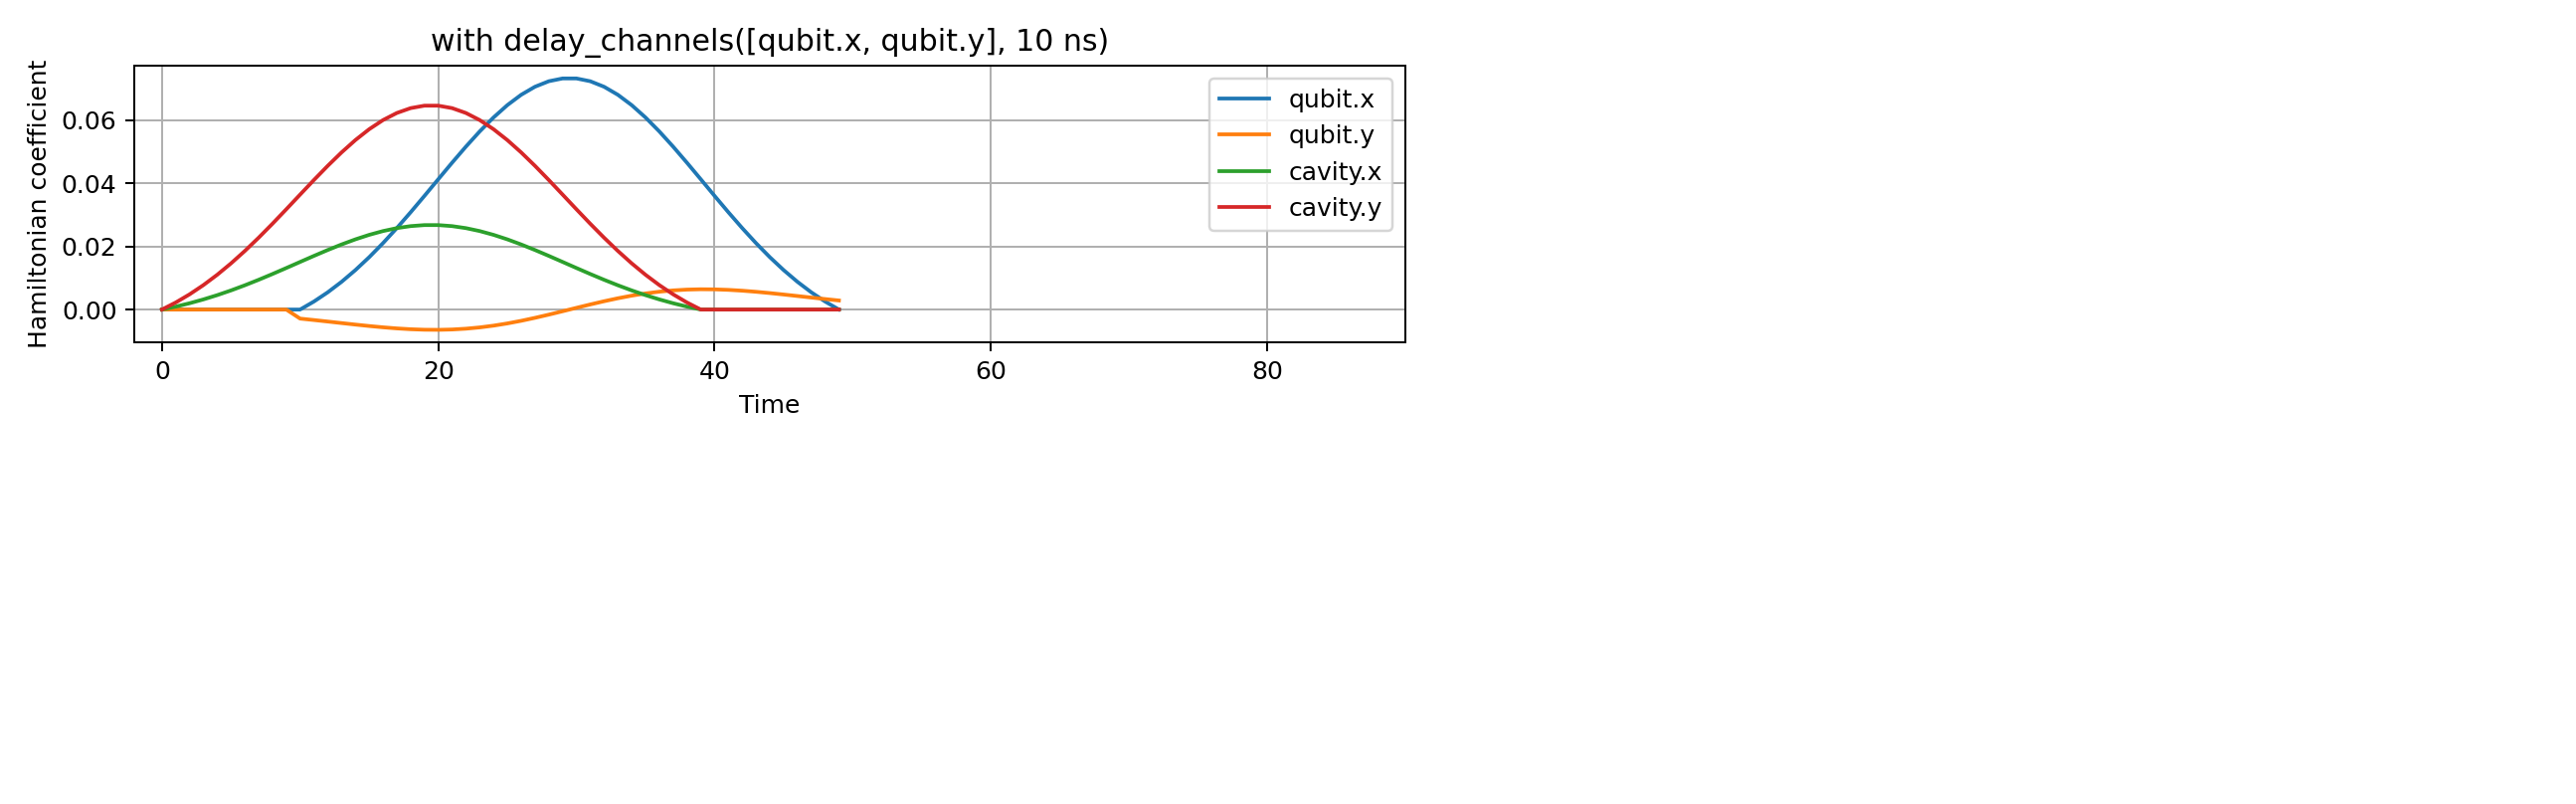

In [5]:
qubit.gaussian_pulse.drag = 5
alpha = 1.5 * np.exp(-1j * np.pi/8)
idle = 10 # ns

def adjust_figsize(fig, ax, width=8, height=2.5):
    ax.set_xlim(-2,90)
    fig.set_size_inches(width, height)
    fig.tight_layout()

# without sync
seq = get_sequence(system)
qubit.rotate_x(np.pi)
cavity.displace(alpha)
fig, ax = seq.plot_coefficients(subplots=False)
ax.set_title('without sync()')
adjust_figsize(fig, ax)

# with sync
seq = get_sequence(system)
qubit.rotate_x(np.pi)
sync()
cavity.displace(alpha)
fig, ax = seq.plot_coefficients(subplots=False)
ax.set_title('with sync()')
adjust_figsize(fig, ax)

# with delay
seq = get_sequence(system)
qubit.rotate_x(np.pi)
delay(idle)
cavity.displace(alpha)
fig, ax = seq.plot_coefficients(subplots=False)
ax.set_title(f'with delay({idle} ns)')
adjust_figsize(fig, ax)

# delay_channels - cavity
seq = get_sequence(system)
qubit.rotate_x(np.pi)
delay_channels({'cavity.x': cavity.x, 'cavity.y': cavity.y}, idle)
cavity.displace(alpha)
fig, ax = seq.plot_coefficients(subplots=False)
ax.set_title(f'with delay_channels([cavity.x, cavity.y], {idle} ns)')
adjust_figsize(fig, ax)

# delay_channels - qubit
seq = get_sequence(system)
delay_channels({'qubit.x': qubit.x, 'qubit.y': qubit.y}, idle)
qubit.rotate_x(np.pi)
cavity.displace(alpha)
fig, ax = seq.plot_coefficients(subplots=False)
ax.set_title(f'with delay_channels([qubit.x, qubit.y], {idle} ns)')
adjust_figsize(fig, ax)

## Under the hood

As mentioned [above](#Quickstart), a `PulseSequence` is compiled into a `CompiledPulseSequence` before it is simulated. A `CompiledPulseSequence` is associated with a `System`, and is composed of `Operations`. 

### Operations

An `Operation` is an object with a certain `duration` (in nanoseconds) and a string-keyed dictionary of `terms`, where each term is an instance of `HTerm`.

`HTerms` have the following signature:

- `H (qutip.Qobj)`:
    - `qutip.Qobj` representing a given operator.
- `coeffs (optional, scalar or array-like or callable, default: 1)`:
    - Coefficients for the above operator. If `coeffs` is a scalar, then the operator has constant coefficients. If `coeffs` is a `list` or `np.ndarray`, then `coeffs` represents the time-dependent coefficients of the operator (one coefficient per nanosecond). If `coeffs` is a callable, then it is interpreted as a function with the signature `coeffs(time_in_ns, *args, **kwargs) -> array_of_coefficients`.
- `args (optional, sequence, default: None)`:
    - Positional arguments to be passed to `coeffs` if `coeffs` is a callable.
- `kwargs (optional, dict, default: None)`:
    - Keyword arguments to be passed to `coeffs` if `coeffs` is a callable.

Terms that are applied to the Hamiltonian simultaneously can be packaged together in an `Operation`, which has the signature:

- `duration (int)`:
    - Length of the operation in nanoseconds.
- `terms (dict[str, HTerm])`:
    - Dictionary of the form `{channel_name: term}`, where `channel_name` is a string specifying the a label for the term's operator and `term` is an instance of `HTerm`.


### HamiltonianChannels

The `CompiledPulseSequence` class tracks the timing/scheduling of different `Operations` and produces a time-dependent Hamiltonian in a format that can be injested by [qutip.mesolve()](http://qutip.org/docs/4.1/apidoc/functions.html#module-qutip.mesolve). The unsung hero of `CompiledPulseSequence` is a class called `HamiltonianChannels`, which has the following attributes:

- `tmin (float)`: sequence start time in ns.
- `tmax (float)`: sequence end time in ns, i.e. last time point for which a coefficient is defined.
- `times (np.ndarray)`: array of current sequence time in ns.
- `channels (dict)`: dictionary of the form `{channel_name: {'H': H_op, 'time_dependent': bool, 'coeffs': array_of_coeffs, 'delay': channel_delay}}`. `array_of_coeffs` specifies the coefficients for operator `H_op` at every time step in the sequence. `channel_delay` is the total delay for that channel relative to any un-delayed channels. This value is incremented whenever the `delay_channel()` function is called on a given channel.

The two important methods of `HamiltonianChannels` are `add_operation()` and `build_hamiltonian()`.

- `add_operation()` takes in an `Operation` and directs each of its `terms` to the appropriate Hamiltonian `channel`. Then, it pads the `coeffs` for each channel to ensure that all channels are perfectly aligned in time.
- `build_hamiltonian()` converts the dictionary of `channels` into a list that can be interpreted by `qutip.mesolve()` in order to be simulated.

In [6]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.5.2
Numpy,1.20.0
SciPy,1.6.0
matplotlib,3.3.4
Cython,0.29.21
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.19.0
Python,"3.9.1 (default, Dec 11 2020, 06:28:49) [Clang 10.0.0 ]"
OS,posix [darwin]
